<a href="https://colab.research.google.com/github/samyakjain0112/Generative-models-papers-and-code/blob/master/Conditional_Generative_Adverserial_Networks_original_with_mode_collapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing all requirements
import torch as torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch.nn as nn
from torch.nn.functional import relu as Relu
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.decomposition import PCA
import torch.nn.functional as F

In [0]:
#using the inbuilt Dataset class where all data is loaded into the cpu memory and using getitem we can get the data by just passing the corresponding index4

#VARIABLE=DATASET

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
#loading all the data using Dataloaader inbuilt class it loads all the data again into the cpu memory without making a copy because it uses iter for it and even if suffle examples is true then also no cpy is 
#required it just reshuffles the order of the iteraror in the list. 
#NOTE: only when we will load the data for training in the training class then the data will be needed to be loaded in the gpu memory
batch_size=32
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [0]:

#Usually in the model class we need to inherit from nn.Module and use super class code otherwise the forward will not run.

#VARIABLE: SELF.NUM_LAYERS

class model_generator(torch.nn.Module):
  def __init__(self,batch_size=32):
    super(model_generator,self).__init__()
    self.batch_size=batch_size
    self.num_layers=1
    self.filter_size=28
    self.mean=100
    self.class_size=10
    self.std=100
    self.g_input_without_label=100
    self.g_input_dim=110
    self.g_output_dim=self.filter_size*self.filter_size
    self.batcher=1
    self.labeler_batch_size=torch.from_numpy(np.zeros([self.batch_size,self.class_size],dtype='float32')).cuda()
    self.labeler_batcher=torch.from_numpy(np.zeros([self.batcher,self.class_size],dtype='float32')).cuda()
    self.fc1 = nn.Linear(self.g_input_dim, 128)
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
    self.fc4 = nn.Linear(self.fc3.out_features, self.g_output_dim)


  def forward(self,x_input,label,latent_space=False,latent=None,marker=False,plot=False,batcher=1):
    #taking x_input as input for coding simplicity but not using it in any way
    if latent_space==True or marker==True or plot==True:
      self.x=(torch.randn(batcher,self.g_input_without_label)).cuda()
      vec=self.labeler_batcher
      vec[0][int(label)]=1
      self.x=torch.cat((self.x,vec),1)

    else:
      self.x=(torch.randn(self.batch_size,self.g_input_without_label)).cuda()
      vec=self.labeler_batch_size
      for i in range(self.batch_size):
        vec[i][int(label[i].item())]=1
      self.x=torch.cat((self.x,vec),1)
    
    x = F.leaky_relu(self.fc1(self.x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    if plot==True:
      return x
    if latent_space==True:
      return x
    if marker==True:
      x=latent
    x = F.leaky_relu(self.fc3(x), 0.2)
    return torch.tanh(self.fc4(x))


In [0]:
#Usually in the model class we need to inherit from nn.Module and use super class code otherwise the forward will not run.

#VARIABLE: SELF.NUM_LAYERS

class model_discriminator(torch.nn.Module):
  def __init__(self,batch_size=32):
    super(model_discriminator,self).__init__()
    self.batch_size=batch_size
    self.num_layers=1
    self.filter_size=28

    self.class_size=10
    self.d_input_dim=self.filter_size*self.filter_size+self.class_size

    self.fc1 = nn.Linear(self.d_input_dim, 1024)
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
    self.fc4 = nn.Linear(self.fc3.out_features, 1)
    

  def forward(self,x,latent_space=False,latent=None,marker=False,plot=False):
      x = F.leaky_relu(self.fc1(x), 0.2)
      x = F.dropout(x, 0.3)
      x = F.leaky_relu(self.fc2(x), 0.2)
      if plot==True:
        return x
      if latent_space==True:
        return x
      if marker==True:
        x=latent
      x = F.dropout(x, 0.3)
      x = F.leaky_relu(self.fc3(x), 0.2)
      x = F.dropout(x, 0.3)
      return torch.sigmoid(self.fc4(x))
"""
    if plot==True:
      return x
    if latent_space==True:
      return x
    if marker==True:
      x=latent
    x=self.layer3(x)
    x=Relu(x)
    x=torch.flatten(x,1)
    x=self.layer4(x)
    x=Relu(x)
    x=self.layer5(x)
    x=torch.sigmoid(x)
    #print(x.size())
    #x=x.cpu().detach().numpy()
    #x=np.array(np.amax(x,axis=1))
    
    
    #print(x.size())

    return x
"""

'\n    if plot==True:\n      return x\n    if latent_space==True:\n      return x\n    if marker==True:\n      x=latent\n    x=self.layer3(x)\n    x=Relu(x)\n    x=torch.flatten(x,1)\n    x=self.layer4(x)\n    x=Relu(x)\n    x=self.layer5(x)\n    x=torch.sigmoid(x)\n    #print(x.size())\n    #x=x.cpu().detach().numpy()\n    #x=np.array(np.amax(x,axis=1))\n    \n    \n    #print(x.size())\n\n    return x\n'

In [0]:
"""

class model_generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(model_generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class model_discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(model_discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
        
"""


'\n\nclass model_generator(nn.Module):\n    def __init__(self, g_input_dim, g_output_dim):\n        super(model_generator, self).__init__()       \n        self.fc1 = nn.Linear(g_input_dim, 256)\n        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)\n        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)\n        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)\n\n    \n    # forward method\n    def forward(self, x): \n        x = F.leaky_relu(self.fc1(x), 0.2)\n        x = F.leaky_relu(self.fc2(x), 0.2)\n        x = F.leaky_relu(self.fc3(x), 0.2)\n        return torch.tanh(self.fc4(x))\n    \nclass model_discriminator(nn.Module):\n    def __init__(self, d_input_dim):\n        super(model_discriminator, self).__init__()\n        self.fc1 = nn.Linear(d_input_dim, 1024)\n        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)\n        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)\n        

In [0]:
#latent space visualization
class modify_space(object):
  def __init__(self,importer,test_gen,label=1,label2=2,num_latents=10):
    self.batch_size=1
    self.label=label
    self.num_layers=1
    self.filter_size=28
    self.label2=label2
    self.test_gen=test_gen
    self.num_latents=num_latents
    self.net_generator=importer.net_generator
    self.net_discriminator=importer.net_discriminator
    self.generate()
    self.latent()


  def generate(self):
    w=0
    e=0
    print(1)
    for (image,label) in self.test_gen:
      if w==1:
        break
      for i in range(len(label)):
        if (label[i].item())==self.label:
          self.image=np.reshape(image[i],[self.batch_size, self.num_layers*self.filter_size*self.filter_size]).cuda()

          self.label=label[i].cuda()
          w=1
          break
    for (image,label) in self.test_gen:
      if e==1:
        break
      for i in range(len(label)):
        if (label[i].item())==self.label2:
          self.image2=np.reshape(image[i],[self.batch_size, self.num_layers*self.filter_size*self.filter_size]).cuda()
          self.label2=label[i].cuda()
          e=1
          break

  def latent(self):
    latent1=self.net_generator(self.image,latent_space=True,label=self.label)
    latent2=self.net_generator(self.image2,latent_space=True,label=self.label2)
    for count in range(self.num_latents+1):
      input_latent=(latent1*(count/(self.num_latents))+latent2*(1-count/self.num_latents))
      output=self.net_generator(self.image2,latent=input_latent,marker=True,label=self.label)
      output=output.view(1, 1,self.filter_size ,self.filter_size ) 
      save_image(output,'latent_layer1_'+str(count)+'.png')

In [0]:
#visualizing the latent space points in two dimenions using principal component analysis
a=0
class plotter(object):
  def __init__(self,render):
    self.batch_size=1
    self.test_gen=test_gen
    self.net_generator=render.net_generator
    self.net_discriminator=render.net_discriminator
    self.num_layers=1
    self.filter_size=28
    self.latent=[]
    self.latent_size=256
    self.label_array=[]
    self.visualize()
   
  def visualize(self):
    for (image,label) in self.test_gen:
      for i in range(len(label)):
        latent=self.net_generator(np.reshape(image[i],[self.batch_size,self.num_layers*self.filter_size*self.filter_size]).cuda(),plot=True,label=label[i].item()).cpu().detach().numpy()
        latent_x=np.reshape(latent,(self.latent_size))
        self.latent.append(latent_x)
        
        self.label_array.append(label[i].item())
        #feat_cols = ['feature'+str(i) for i in range(latent_x.shape[1])]
        #latent=pd.DataFrame(latent_x,columns=feat_cols)
        #print(latent.shape)
        #print(latent)

    pca_latent = PCA(n_components=2)
  
    twodim_pca = pca_latent.fit_transform(np.array(self.latent))
    colormap = np.array(['r', 'g', 'b','pink','orange','lightblue','black','brown','yellow','white'])
    for i in range(10):
      temp1=[]
      temp2=[]
      
      for j in range(len(self.label_array)):

        if self.label_array[j]==i:
          temp1.append(twodim_pca[j][0])
          temp2.append(twodim_pca[j][1]) 
      plt.scatter(temp1,temp2,c=colormap[i])
    plt.show()
    

In [0]:
#MAIN DO NOT TOUCH IT
net_generator=model_generator().cuda()
net_discriminator=model_discriminator().cuda()
lr=0.000025
opt_generator=torch.optim.Adam(net_generator.parameters(),lr)
opt_discriminator=torch.optim.Adam(net_discriminator.parameters(),lr)

In [0]:
#If we are building a class without using any functionality of any other class then object can be written it means that the class will return an object type dataset
#However if we write like data.Datasets of Sampler then it means that it will have functionality of the superclass data.Datasets or Sampler however ultimately these super classes will also return an object.
#so here in a way we are returning an object of the super class via the sub class.
#BUILDING A SIMPLE AUTOENCODER WHICH JUST AIMS AT RECONSTRUCTION WITHOUT ANY STOCHASTICITY


class training(object):

  def __init__(self,epochs=30,train_g=train_gen,test_g=test_gen,generate_latent=False,plot=False,opt_generator=opt_generator,opt_discriminator=opt_discriminator):
    self.epochs=epochs
    self.lr=lr
    self.train_gen=train_g
    self.batch_size=32
    self.test_gen=test_g
    self.device='cuda'
    self.num_layers=1
    self.filter_size=28
    self.net_generator=net_generator
    self.net_discriminator=net_discriminator
    self.loss=torch.nn.BCELoss()
    self.opt_discriminator=opt_discriminator
    self.opt_generator=opt_generator
    self.generation_iters=1
    self.d_iters=3
    self.class_size=10
    self.labeler=torch.from_numpy(np.zeros([self.batch_size,self.class_size],dtype='float32')).cuda()
    self.train()
    
    if generate_latent==True:
      modify_space(self,test_gen)
    if plot==True:
      plotter(self)
    self.test()


  def train(self):
    for epoch_no in range(self.epochs):
      counter=0
      for (image,label) in self.train_gen:
        img=image.to(self.device)
        lab_real=torch.from_numpy(np.ones([self.batch_size,1],np.float32)).to(self.device)
        lab_fake=torch.from_numpy(np.zeros([self.batch_size,1],np.float32)).to(self.device)

        #train_discriminator
        #self.opt_generator.zero_grad()

        self.opt_discriminator.zero_grad()
        """random_choice=np.random.choice([0,1])
        if random_choice==0:
          input_label=lab_fake
          input_img=output_generator[:,:,:27,:27]
          print("fake_image",input_img.size())
        else:
          input_label=lab_real
          input_img=img[:,:,:27,:27]
          print("real_image",input_img.size())
          """
        loss_d=0
        for i in range(self.d_iters):  
          output_generator=self.net_generator(img,label).to(self.device)
          vec=self.labeler
          for i in range(self.batch_size):
            vec[i][int(label[i].item())]=1

          output_generator=torch.cat((output_generator,vec),1)

          logits_fake = self.net_discriminator(output_generator).to(self.device)


          logits_real = self.net_discriminator(torch.cat((img.view(self.batch_size,self.num_layers*self.filter_size*self.filter_size),vec),1)).to(self.device)

          loss_discriminator_real = self.loss(logits_real,lab_real)
          loss_discriminator_fake = self.loss(logits_fake,lab_fake)
          loss_discriminator=loss_discriminator_real+loss_discriminator_fake
          loss_discriminator.backward(retain_graph=True)
          self.opt_discriminator.step()
          loss_d+=loss_discriminator
        #discriminator one iteration complete

        #train_generator
        tot_loss=0
        for i in range(self.generation_iters):
          img=0
          self.opt_generator.zero_grad()
          #self.opt_discriminator.zero_grad()
          output_generator=self.net_generator(img,label).to(self.device)
          output_generator=torch.cat((output_generator,vec),1)
          #print("fake_image",output_generator.size())
          logit_disc = self.net_discriminator(output_generator).to(self.device)
          loss_generator = self.loss(logit_disc,lab_real)
          tot_loss+=loss_generator
          loss_generator.backward()
          self.opt_generator.step()
        #One generator iteration completed
        counter+=1
        print("ITERATION_NO.:",counter ,"LOSS_Generator:",tot_loss.item()/self.generation_iters ,"LOSS_Discriminator:",loss_d.item()/self.d_iters)
      print("EPOCH OVER:",epoch_no)
   
  def test(self):
    count=0
    for (image,label) in self.train_gen:
      img=image[0].to(self.device)
      lab=label.to(self.device)
      outputs = self.net_generator(img,label).view(32,1,28,28)
      count+=1
      print("Image_no",count)
      if count%100==0:
        save_image(outputs,'testing'+str(count)+'.png')
       




Streaming output truncated to the last 5000 lines.
ITERATION_NO.: 631 LOSS_Generator: 5.806629180908203 LOSS_Discriminator: 0.11789703369140625
ITERATION_NO.: 632 LOSS_Generator: 5.012133598327637 LOSS_Discriminator: 0.11223995685577393
ITERATION_NO.: 633 LOSS_Generator: 4.970308780670166 LOSS_Discriminator: 0.02246405929327011
ITERATION_NO.: 634 LOSS_Generator: 4.728080749511719 LOSS_Discriminator: 0.13024228811264038
ITERATION_NO.: 635 LOSS_Generator: 4.306203842163086 LOSS_Discriminator: 0.12628276149431863
ITERATION_NO.: 636 LOSS_Generator: 4.011298179626465 LOSS_Discriminator: 0.05422412355740865
ITERATION_NO.: 637 LOSS_Generator: 4.734061241149902 LOSS_Discriminator: 0.09575721621513367
ITERATION_NO.: 638 LOSS_Generator: 4.778985500335693 LOSS_Discriminator: 0.05302496751149496
ITERATION_NO.: 639 LOSS_Generator: 5.104422092437744 LOSS_Discriminator: 0.0558294008175532
ITERATION_NO.: 640 LOSS_Generator: 5.261897087097168 LOSS_Discriminator: 0.03660347064336141
ITERATION_NO.: 641 L

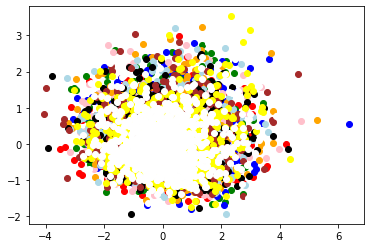

Image_no 1
Image_no 2
Image_no 3
Image_no 4
Image_no 5
Image_no 6
Image_no 7
Image_no 8
Image_no 9
Image_no 10
Image_no 11
Image_no 12
Image_no 13
Image_no 14
Image_no 15
Image_no 16
Image_no 17
Image_no 18
Image_no 19
Image_no 20
Image_no 21
Image_no 22
Image_no 23
Image_no 24
Image_no 25
Image_no 26
Image_no 27
Image_no 28
Image_no 29
Image_no 30
Image_no 31
Image_no 32
Image_no 33
Image_no 34
Image_no 35
Image_no 36
Image_no 37
Image_no 38
Image_no 39
Image_no 40
Image_no 41
Image_no 42
Image_no 43
Image_no 44
Image_no 45
Image_no 46
Image_no 47
Image_no 48
Image_no 49
Image_no 50
Image_no 51
Image_no 52
Image_no 53
Image_no 54
Image_no 55
Image_no 56
Image_no 57
Image_no 58
Image_no 59
Image_no 60
Image_no 61
Image_no 62
Image_no 63
Image_no 64
Image_no 65
Image_no 66
Image_no 67
Image_no 68
Image_no 69
Image_no 70
Image_no 71
Image_no 72
Image_no 73
Image_no 74
Image_no 75
Image_no 76
Image_no 77
Image_no 78
Image_no 79
Image_no 80
Image_no 81
Image_no 82
Image_no 83
Image_no 84
I

In [0]:
#here is all it begins and ends
obj=training(plot=True,generate_latent=True)

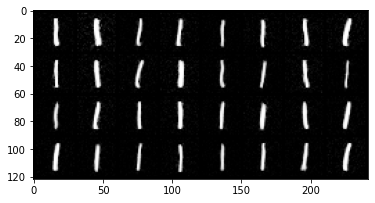

In [0]:

#test image visualization
img=cv2.imread('testing1000.png')
plt.imshow(img)


WE CAN SEE THE MIXING OCCURNG IN THE LATENT SPACE AND ESPECIALLY BECAUSE OF LOW DIMENSIONALITY 522 THOUGH THE POINTS IN LATENT SPACE ARE DISCRETE AND KIND OF ONE TO ONE MAPPING BUT THEY STILL SEEM TO BE QUITE CONTINUOUS. TAKING A HIGHER DIMENSIONAL DATASET MAY SHOW THE SPARSITY IN THE LATENT IN A BETTER WAY.

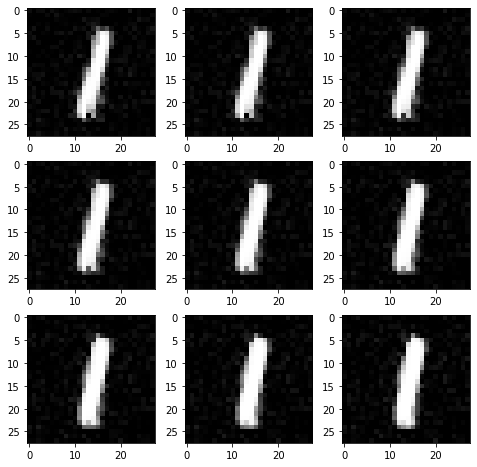

In [0]:
#layer3 visualization
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img=cv2.imread('latent_layer1_'+str(i)+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#layer2 visualization
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img=cv2.imread('latent_layer2_'+str(i)+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#layer1 visualization
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img=cv2.imread('latent_layer1_'+str(i)+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

SO IT SEEMS THAT THE LATENT SPACE IS VERY CONTINUOUS BUT IN REALITY IT IS DISCRETE IN CASE OF A NORMAL AUTOENCODER TO VISUALIZE IT WE NEED A LARGER DIMENSION DATASET TO PROOVE IT WE NEED TO PLOT THE LATENT SPACE BY CONVERTING IT INTO TWO DIMENSIONS USING PCA

In [0]:
#here is all it begins and ends
obj=training(plot=True)


In [0]:
print(a)